# A Rate-Based Model of Neural Activity-Dependent Homeostatic Plasticity

###Goals/Objectives/Questions:

1. [***Correlation structure***] It is hypothesized that the relative numbers of ion channels embedded in the membrane of neurons maintained by activity-dependent homeostatic plasticity (ADHP) is related to the proportion in which they are inserted in response to hypo- or hyper-activity (ADHP mechanism details). However, these correlation structures could more readily be explained by the degeneracy of neural parameter space -- the fact that multiple ion channel configurations can produce the same average activity levels. Therefore, we aim to show that the same correlation structures can be produced regardless of ADHP mechanism details. This would support the explanation that it is instead a consequence of parameter space degeneracy.

2. [***Rate-based Modeling of ADHP*** - *if we get to it*] Up to this point, models of activity-dependent homeostatic plasticity (ADHP) have used the deviation of calcium concentration from a certian target level to determine how to change the maximum conductance values for various ionic currents. It has been suggested that this target level might be genetically determined, varying by cell-type and having great influence on what kind of activity profile the neuron is set up to maintain. However, the abstract concept of a target concentration is not biologically realistic. In reality, ion channel proteins are "turning over" all the time, degrading and being replaced at certain rates. Increasing or decreasing these rates as a function of Calcium concentration shifts the equilibrium concentration of ion channels in the membrane, which adjusts the activity of the neuron and the calcium concentration in turn. Can a model of this maintain various activity profiles without the need to specify an abstract target calcium concentration?

###Main Inpsiration Paper(s):


In [ ]:
%%capture
#output is suppressed with %%capture
! %pip install tellurium

In [ ]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

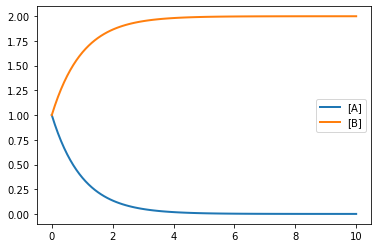

In [ ]:
#testing tellurium functionality
r = tellurium.loada('''
R1: A -> B; k1*A
A=1
B=1
k1 = 1''')

r.simulate(0,10,100)
r.plot()

**Step 1**: Recreate individual timeseries from Figure 1

In [ ]:
#Grant's version
model = '''
R1: -> Vm ; (g1*(E1-Vm) + g2*(E2-Vm) + g3*(E3-Vm)) / Cm
R2: -> Ca ; (Vm - Ca) / TauCa                                  # need to figure out how they model c(Vm)
R3: -> g1 ; g1*(Ca - Ct) / Tau1
R4: -> g2 ; g2*(Ca - Ct) / Tau2
R5: -> g3 ; g3*(Ca - Ct) / Tau3

g1 = 0.02; g2 = 0.02; g3 = 0.1;        # conductances
E1 = -90; E2 = -30; E3 = 50;           # corresponding reversal potentials
Ca = 0.2;                              # calcium concentration
Vm = 0.1;                              # membrane potential
Ct = 0.4;                              # target 
Cm = 1;
Tau1 = 10;
Tau2 = 10;
Tau3 = 10;
TauCa = 10;
'''

r = te.loada(model)

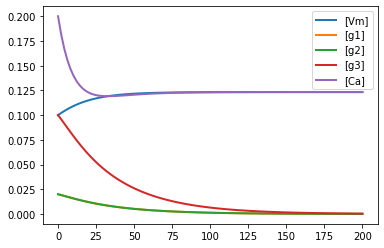

In [ ]:
r.simulate(0,200,100)
r.plot()

In [ ]:
#my version
model = '''
R1: -> Vm ; (g1*(E1-Vm) + g2*(E2-Vm) + g3*(E3-Vm)) / Cm
R2: -> Ca ; (A*(e^(b*Vm)) - Ca) / TauCa
R3: -> g1 ; g1*(Ca - Ct) / Tau1
R4: -> g2 ; g2*(Ca - Ct) / Tau2
R5: -> g3 ; g3*(Ca - Ct) / Tau3

e = 2.7182818284                            #Euler's number

g1 = 100; g2 = 20; g3 = 10;            # conductances uS/nF
E1 = -90; E2 = -30; E3 = 50;           # corresponding reversal potentials
A = 109.2                              # uM (from experimental fitting)
b = .08                                # mV^-1 (from experiment fitting)
Ca = 0.2;                              # calcium concentration
Vm = -50;                              # membrane potential
Ct = 1;                                # (uM) target 
Cm = 1;                                # Membrane capacitance
Tau1 = 4000;
Tau2 = -6000;
Tau3 = -1000;
TauCa = 100;                           #ms
'''

r = te.loada(model)

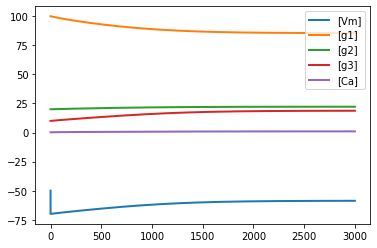

end [Ca] 0.9947389735705077


In [ ]:
r.reset()
result = r.simulate(0,3000,30000)
r.plot()
print('end [Ca]:',result[-1,-1])

Generic Python Model to double-check

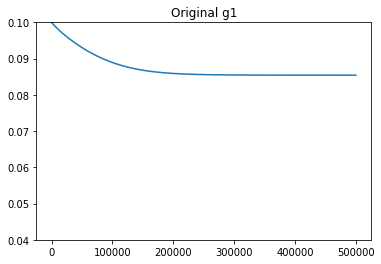

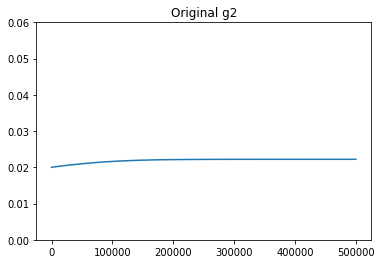

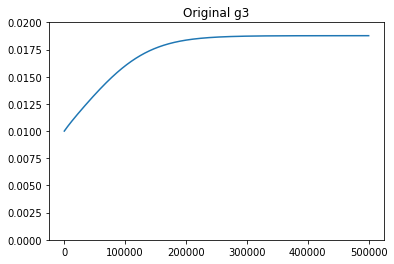

final [Ca] 0.9999484494697508
final Vm -58.66525822735212


In [ ]:
#original tau's (blue in figure)

t = 0
dt = .01
totalSimSteps = 500000
dataoriginal = np.zeros((5,totalSimSteps))             #Tau1 = 4000, Tau2 = -6000, Tau3 = -1000      
#initial values
Vm = -70
Ca = .2
g1 = 100
g2 = 20
g3 = 10

#parameter values 
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = -6000
Tau3 = -1000
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

for i in range(totalSimSteps):
  Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
  Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
  g1 += dt*(g1*(Ca - Ct) / Tau1)
  g2 += dt*(g2*(Ca - Ct) / Tau2)
  g3 += dt*(g3*(Ca - Ct) / Tau3)
  dataoriginal[:,i] = np.array([Ca,Vm,g1,g2,g3])
  t += dt

dataoriginal = np.vstack((np.arange(0,totalSimSteps), dataoriginal))
#print(dataoriginal)
#plt.plot(dataoriginal[0,:],dataoriginal[1,:],label = "Ca")
#plt.plot(dataoriginal[0,:],dataoriginal[2,:],label='Vm')
plt.plot(dataoriginal[0,:],dataoriginal[3,:]/1000,color='tab:blue')
plt.ylim([.04,.1])
plt.title('Original g1')
plt.show()
plt.plot(dataoriginal[0,:],dataoriginal[4,:]/1000,label='g2',color='tab:blue')
plt.ylim([0,.06])
plt.title('Original g2')
plt.show()
plt.plot(dataoriginal[0,:],dataoriginal[5,:]/1000,label='g3',color='tab:blue')
plt.ylim([0,.02])
plt.title('Original g3')
plt.show()

print('final [Ca]',dataoriginal[1,-1])
print('final Vm', dataoriginal[2,-1])

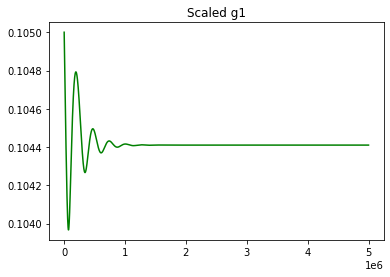

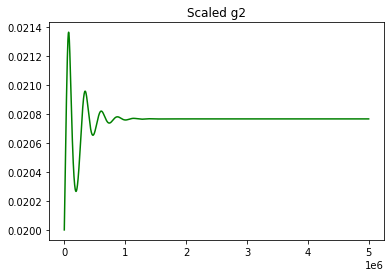

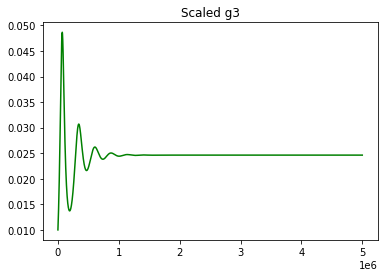

final [Ca] 1.0000000000021998
final Vm -58.6647632917011


In [ ]:
#Scaled tau's (green in figure)

t = 0
dt = .001
totalSimSteps = 5000000     
datascaled = np.zeros((5,totalSimSteps))                 #Tau1 = 4000, Tau2 = -6000/10, Tau3 = -1000/40   
#initial values
Vm = -50
Ca = .2
g1 = 105
g2 = 20
g3 = 10

#parameter values 
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = -6000/10
Tau3 = -1000/40
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

for i in range(totalSimSteps):
  Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
  Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
  g1 += dt*(g1*(Ca - Ct) / Tau1)
  g2 += dt*(g2*(Ca - Ct) / Tau2)
  g3 += dt*(g3*(Ca - Ct) / Tau3)
  datascaled[:,i] = np.array([Ca,Vm,g1,g2,g3])
  t += dt

datascaled = np.vstack((np.arange(0,totalSimSteps), datascaled))
#print(datascaled)
#plt.plot(datascaled[0,:],datascaled[1,:],label = "Ca")
#plt.plot(datascaled[0,:],datascaled[2,:],label='Vm')
plt.plot(datascaled[0,:],datascaled[3,:]/1000,label='g1',color='green')
plt.title('Scaled g1')
plt.show()
plt.plot(datascaled[0,:],datascaled[4,:]/1000,label='g2',color='green')
plt.title('Scaled g2')
plt.show()
plt.plot(datascaled[0,:],datascaled[5,:]/1000,label='g3',color='green')
plt.title('Scaled g3')
plt.show()

print('final [Ca]',datascaled[1,-1])
print('final Vm', datascaled[2,-1])

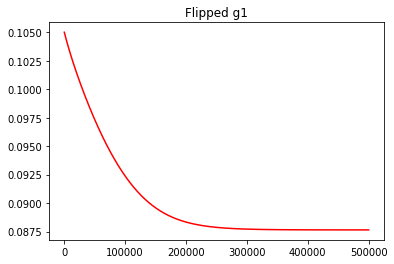

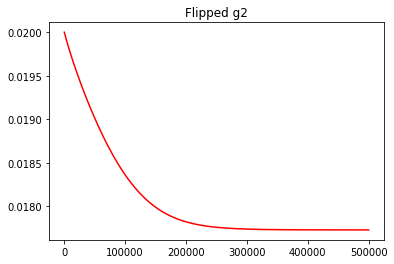

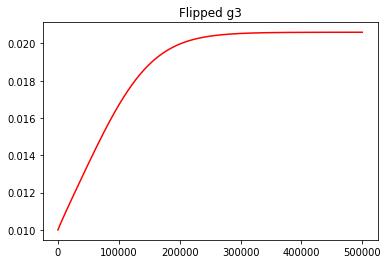

final [Ca] 0.9999316807053102
final Vm -58.66541573205877


In [ ]:
#Flipped tau's (red in figure)

t = 0
dt = .01
totalSimSteps = 500000  
dataflipped = np.zeros((5,totalSimSteps))               #Tau1 = 4000, Tau2 = +6000, Tau3 = -1000   
#initial values
Vm = -70
Ca = .2
g1 = 105
g2 = 20
g3 = 10

#parameter values 
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = 6000  #FLIPPED SIGN
Tau3 = -1000
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

for i in range(totalSimSteps):
  Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
  Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
  g1 += dt*(g1*(Ca - Ct) / Tau1)
  g2 += dt*(g2*(Ca - Ct) / Tau2)
  g3 += dt*(g3*(Ca - Ct) / Tau3)
  dataflipped[:,i] = np.array([Ca,Vm,g1,g2,g3])
  t += dt

dataflipped = np.vstack((np.arange(0,totalSimSteps), dataflipped))
#print(dataflipped)
#plt.plot(dataflipped[0,:],dataflipped[1,:],label = "Ca")
#plt.plot(dataflipped[0,:],dataflipped[2,:],label='Vm')
plt.plot(dataflipped[0,:],dataflipped[3,:]/1000,label='g1',color = 'red')
plt.title('Flipped g1')
plt.show()
plt.plot(dataflipped[0,:],dataflipped[4,:]/1000,label='g2',color = 'red')
plt.title('Flipped g2')
plt.show()
plt.plot(dataflipped[0,:],dataflipped[5,:]/1000,label='g3',color = 'red')
plt.title('Flipped g3')
plt.show()

print('final [Ca]',dataflipped[1,-1])
print('final Vm', dataflipped[2,-1])

**Step 2**: Test from a small cluster of initial conditions (replicate paper)

**Step 3**: Test from a wide variety of initial conditions (Extend paper)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: RuntimeWarning:

invalid value encountered in double_scalars



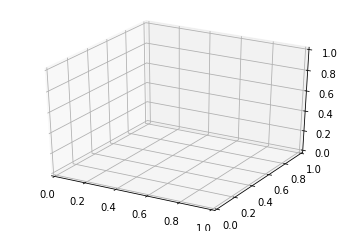

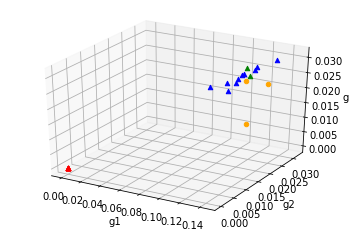

In [ ]:
import random

t = 0
dt = .01
totalSimSteps = 500000
numRandomStartPoints = 10
# ---------------- Original Runs --------------------
dataoriginal = np.zeros((5,totalSimSteps))             #Tau1 = 4000, Tau2 = -6000, Tau3 = -1000      
#initial values
Vm = -70
Ca = .2
g1 = 100
g2 = 20
g3 = 10

#parameter values original
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = -6000
Tau3 = -1000
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

startingPoints = np.zeros((3,numRandomStartPoints))
endingPointsOriginal = np.zeros((3,numRandomStartPoints))
for i in range(numRandomStartPoints):
  g1 = random.uniform(g1 - 20, g1 + 20)
  g2 = random.uniform(g2 - 10, g2 + 10)
  g3 = random.uniform(g3 - 5, g3 + 5)
  startingPoints[:,i] = np.array([g1,g2,g3])
  for j in range(totalSimSteps):
    Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
    Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
    g1 += dt*(g1*(Ca - Ct) / Tau1)
    g2 += dt*(g2*(Ca - Ct) / Tau2)
    g3 += dt*(g3*(Ca - Ct) / Tau3)
    dataoriginal[:,j] = np.array([Ca,Vm,g1,g2,g3])
    t += dt

  endingPointsOriginal[:,i] = np.array([g1,g2,g3])

dataoriginal = np.vstack((np.arange(0,totalSimSteps), dataoriginal))
# ---------------- Flipped Runs --------------------
#initial values flipped
Vm = -70
Ca = .2
g1 = 105
g2 = 20
g3 = 10

#parameter values flipped
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = 6000  #FLIPPED SIGN
Tau3 = -1000
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

dataFlipped = np.zeros((5,totalSimSteps))
endingPointsFlipped = np.zeros((3,numRandomStartPoints))
for i in range(numRandomStartPoints):
  g1 = random.uniform(g1 - 20, g1 + 20)
  g2 = random.uniform(g2 - 10, g2 + 10)
  g3 = random.uniform(g3 - 5, g3 + 5)
  startingPoints[:,i] = np.array([g1,g2,g3])
  for j in range(totalSimSteps):
    Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
    Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
    g1 += dt*(g1*(Ca - Ct) / Tau1)
    g2 += dt*(g2*(Ca - Ct) / Tau2)
    g3 += dt*(g3*(Ca - Ct) / Tau3)
    dataFlipped[:,j] = np.array([Ca,Vm,g1,g2,g3])
    t += dt

  endingPointsOriginal[:,i] = np.array([g1,g2,g3])

dataFlipped = np.vstack((np.arange(0,totalSimSteps), dataoriginal))

# ---------------- Scaled Runs --------------------
#initial values scaled
Vm = -50
Ca = .2
g1 = 105
g2 = 20
g3 = 10

#parameter values scaled
Ct = 1                                # (uM) target 
Cm = 1                                # Membrane capacitance
Tau1 = 4000
Tau2 = -6000/10
Tau3 = -1000/40
TauCa = 100  
A = 109.2                              # uM (from experimental fitting)
b = .08 

dataScaled = np.zeros((5,totalSimSteps)) 
endingPointsScaled = np.zeros((3,numRandomStartPoints))
for i in range(numRandomStartPoints):
  g1 = random.uniform(g1 - 20, g1 + 20)
  g2 = random.uniform(g2 - 10, g2 + 10)
  g3 = random.uniform(g3 - 5, g3 + 5)
  startingPoints[:,i] = np.array([g1,g2,g3])
  for j in range(totalSimSteps):
    Vm += dt*((g1*(-90-Vm) + g2*(-30-Vm) + g3*(50-Vm)) / Cm)
    Ca += dt*((A*(np.exp(b*Vm)) - Ca) / TauCa)
    g1 += dt*(g1*(Ca - Ct) / Tau1)
    g2 += dt*(g2*(Ca - Ct) / Tau2)
    g3 += dt*(g3*(Ca - Ct) / Tau3)
    dataScaled[:,j] = np.array([Ca,Vm,g1,g2,g3])
    t += dt

  endingPointsScaled[:,i] = np.array([g1,g2,g3])


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

dataoriginal = np.vstack((np.arange(0,totalSimSteps), dataoriginal))
for i in range(len(startingPoints[0,:])):
    ax.scatter(startingPoints[0,i]/1000, startingPoints[1,i]/1000, startingPoints[2,i]/1000, marker='o', color='orange') # orange for starting point
    ax.scatter(endingPointsOriginal[0,i]/1000, endingPointsOriginal[1,i]/1000, endingPointsOriginal[2,i]/1000, marker='^', color='blue')        # blue for original
    ax.scatter(endingPointsScaled[0,i]/1000, endingPointsScaled[1,i]/1000, endingPointsScaled[2,i]/1000, marker='^', color='green')        # green for scaled
    ax.scatter(endingPointsFlipped[0,i]/1000, endingPointsFlipped[1,i]/1000, endingPointsFlipped[2,i]/1000, marker='^', color='red')        # red for flipped

ax.set_xlabel('g1')
ax.set_ylabel('g2')
ax.set_zlabel('g3')

plt.show()

**Step 4**: Analyze and contrast correlation structure in both cases

Replicate paper's method of analyzing this (bottom of figure 1). Ideally, replicate their results when using thier small subset of initial points, but show that it breaks down with more initial points

*New questions to ask:*
*   Time-series level:

> * Oscillations in green???
*   Are there initial conditions (especially in the flipped/anti-homeostatic case) where a steady state is not reached (or all conductances go to zero)? I expect this to be the case when more initial conditions are considered

*   Parameter space level:

> * Noise in the system-> stable results? (Glazier's suggestion)
*What are the trajectories through parameter space? (Glazier's suggestion)
*Map basin of attraction of $Ca^{2+}$ steady state




**Step 5**: Construct Rate-Based Model